# Wrangle and Analyze Data

<a id='TC'></a>
## Table of Contents
- [Introduction](#intro)
- [Part I - Gathering Data](#DG)
- [Part II - Assessing Data](#DA)
- [Part III - Cleaning Data](#DC)
- [Part IV - Analyzing Data](#AD)


<a id='intro'></a>
### Introduction

Data wrangling is a core skill that everyone who works with data should be familiar with since so much of the world's data isn't clean. 

In this project, We will use [tweepy](https://docs.tweepy.org/en/v3.2.0/api.html#API) library to query Twitter's API for data included in the [WeRateDogs](https://twitter.com/dog_rates) Twitter archive. This data will include retweet count and favorite count. We will develop some code to create an API object that will be used to gather Twitter data. After querying each [tweet ID](https://stackoverflow.com/questions/28384588/twitter-api-get-tweets-with-specific-id), we will write its [JSON](https://stackabuse.com/reading-and-writing-json-to-a-file-in-python/) data to a `tweet_json.txt` file with each tweet's JSON data on its own line. We will then read this file, line by line, to create a pandas DataFrame that will be assessed and cleaned. Finally, we will work on analyzing our wrangled data.

#### Key Points
Key points to keep in mind when data wrangling for this project:

>We only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.

>In this project, it is required to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset although assessing and cleaning the entire dataset completely would require a lot of time.

>Cleaning includes merging individual pieces of data according to the rules of tidy data.

>The fact that the rating numerators are greater than the denominators do not have to be cleaned. This unique rating system is a big part of the popularity of WeRateDogs.

>We do not need to gather the tweets beyond August 1st, 2017. We can, but note that We won't be able to gather the image predictions for these tweets since we don't have access to the algorithm used.


<a id='DG'></a>
### Part I - Gathering Data        >>>>>>> [Back To Main Menu](#TC)

To get started, let's import our necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import requests
import os
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style="darkgrid")

# Adjust display options for pandas
pd.options.display.max_rows
pd.set_option('display.max_colwidth', None)

#### Loading `twitter-archive-enhanced.csv`
> WeRateDogs downloaded their Twitter archive and sent it to Udacity via email exclusively to use in this project. This archive contains basic tweet data (tweet ID, timestamp, text, etc.) for all 5000+ of their tweets as they stood on August 1, 2017. This file is provided as a starting point, and is downloaded manually from the Udacity server.

In [2]:
df_enhanced=pd.read_csv('twitter_archive_enhanced.csv')
df_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [3]:
# change tweet_id to string because of it is a qualitative data
df_enhanced.tweet_id=df_enhanced.tweet_id.astype(str)

In [4]:
df_enhanced.head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


#### Loading `image_predictions.tsv`
> This file contains a table full of image predictions (the top three only) alongside each tweet ID, image URL, and the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images). In which, every image was run in the WeRateDogs Twitter archive through a neural network that can classify breeds of dogs. That neural network is created previously as one of the projects in Udacity. This file will be downloaded programmatically using the Requests library.

In [5]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
response

<Response [200]>

In [6]:
filename = url.split('/')[-1]
with open(filename, mode = 'wb') as file: # or os.path.join('./', filename) 
    file.write(response.content)

In [7]:
# Loading image predictions file into a DataFrame
df_pred = pd.read_csv(filename, sep='\t')
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [8]:
# change tweet_id to string because of it is a qualitative data by nature
df_pred.tweet_id=df_pred.tweet_id.astype(str)

In [9]:
df_pred.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


#### Streaming Tweets and Saving Their Data in a File Named `tweet_json.txt`


In [10]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# The API Keys, Secrets, and Tokens are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [11]:
# Note: the follwing code will create json file using real access to a twitter developer account.
# Running this code will take about 20 minutes to finish and save json data file.
# Accordingly, running this code without real access to a twitter developer account will save an empty json file.
if consumer_key != 'HIDDEN':  # That condition prevent streaming twitter without real access to a twitter developer account
    # Query Twitter's API for JSON data for each tweet ID in the Twitter archive
    tweet_ids = df_enhanced.tweet_id.values
    len(tweet_ids)
    count = 0
    fails_dict = {}
    start = timer()
    # Save each tweet's returned JSON as a new line in a .txt file
    with open('tweet_json.txt', 'w') as outfile:
        # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
        for tweet_id in tweet_ids:
            count += 1
            print(str(count) + ": " + str(tweet_id))
            try:
                tweet = api.get_status(tweet_id, tweet_mode='extended')
                print("Success")
                json.dump(tweet._json, outfile)
                outfile.write('\n')
            except tweepy.TweepError as e:
                print("Fail")
                fails_dict[tweet_id] = e
                pass
    end = timer()
    print(end - start)
    print(fails_dict)

#### Loading `tweet_json.txt` into DataFrame Named `df_updated`
>In fact, we already have saved our json file via a real access to a twitter developer account. This file has been uploaded to my Google Drive account with sharing link. This file will be downloaded programmatically using the `gdown` library.

In [12]:
# download the json file programmatically. 
import gdown #!pip install gdown
url = 'https://drive.google.com/uc?id=1hb4Zr546ekFDQVYI94N8PcDWKFNh6ZWx'
output = 'tweet_json.txt'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1hb4Zr546ekFDQVYI94N8PcDWKFNh6ZWx
To: C:\Users\Ahmed\Desktop\Data Science Track\Repos\Twitter-Data-Wrangling-Practice\tweet_json.txt
10.6MB [00:02, 5.12MB/s]


'tweet_json.txt'

In [13]:
# read the JSON data from the text file, and load it to a DataFrame
tweets_dicts_list = []

with open('tweet_json.txt', 'r') as json_file:
    tweet = json_file.readline() # read the first tweet where each tweet are presented in json file as a line
    while tweet: # loop only if line is non empty
        tweet_dict = json.loads(tweet) # Convert the tweet to Python dictionary


        keys=['id', 'id_str', 'retweet_count', 'favorite_count']
        dict_items=[(key,int(tweet_dict[key])) for key in keys]
        subdict=dict(dict_items)


        tweets_dicts_list.append(subdict) # add to a list

        tweet = json_file.readline() # read the next tweet


# convert the tweet JSON data dictionary list to a DataFrame
df_updated = pd.DataFrame(tweets_dicts_list)


df_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              2354 non-null   int64
 1   id_str          2354 non-null   int64
 2   retweet_count   2354 non-null   int64
 3   favorite_count  2354 non-null   int64
dtypes: int64(4)
memory usage: 73.7 KB


In [14]:
# change id and id_str to string because of they are qualitative data by nature
df_updated[['id','id_str']]=df_updated[['id','id_str']].astype(str)

#### Saving `df_updated` DataFrame into `twitter-archive-updated.csv` File

In [15]:
df_updated.to_csv('twitter-archive-updated.csv', index = False)

<a id='DA'></a>
### Part II - Assessing Data >>>>>>> [Back To Main Menu](#TC)

In this section, we should inspect the data to find any quality or tidiness issues.

#### Assessing `df_enhanced` DataFrame.

In [16]:
df_enhanced.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
43,884162670584377345,NaN,NaN,2017-07-09 21:29:42 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Yogi. He doesn't have any important dog meetings today he just enjoys looking his best at all times. 12/10 for dangerously dapper doggo https://t.co/YSI00BzTBZ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/884162670584377345/photo/1,12,10,Yogi,doggo,None,None,None
436,820314633777061888,NaN,NaN,2017-01-14 17:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",We are proud to support @LoveYourMelon on their mission to put a hat on every kid battling cancer. They are 14/10\n\nhttps://t.co/XQlmPTLHPl https://t.co/ZNIkkHgtYE,NaN,NaN,NaN,"https://www.loveyourmelon.com/pages/ourstory,https://twitter.com/dog_rates/status/820314633777061888/photo/1,https://twitter.com/dog_rates/status/820314633777061888/photo/1,https://twitter.com/dog_rates/status/820314633777061888/photo/1",14,10,None,None,None,None,None
1215,715009755312439296,NaN,NaN,2016-03-30 02:56:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Siba. She's remarkably mobile. Very sleepy as well. 12/10 would happily transport https://t.co/TjnI33RE1i,NaN,NaN,NaN,https://twitter.com/dog_rates/status/715009755312439296/photo/1,12,10,Siba,None,None,None,None
1449,696100768806522880,NaN,NaN,2016-02-06 22:38:50 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>",This poor pupper has been stuck in a vortex since last week. Please keep her in your thoughts. 10/10 https://t.co/7ODQWHwYDx,NaN,NaN,NaN,https://vine.co/v/i1KWj0vbvA9,10,10,None,None,None,pupper,None
1962,673355879178194945,NaN,NaN,2015-12-06 04:18:46 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Koda. She's a boss. Helps shift gears. Can even drive herself. Still no seat belt (reckless af). 11/10 https://t.co/0zUxlrhZrQ,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/673355879178194945/photo/1,https://twitter.com/dog_rates/status/673355879178194945/photo/1,https://twitter.com/dog_rates/status/673355879178194945/photo/1",11,10,Koda,None,None,None,None


In [17]:
df_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   object 
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [18]:
df_enhanced.nunique()

tweet_id                      2356
in_reply_to_status_id           77
in_reply_to_user_id             31
timestamp                     2356
source                           4
text                          2356
retweeted_status_id            181
retweeted_status_user_id        25
retweeted_status_timestamp     181
expanded_urls                 2218
rating_numerator                40
rating_denominator              18
name                           957
doggo                            2
floofer                          2
pupper                           2
puppo                            2
dtype: int64

In [19]:
df_enhanced.tweet_id.duplicated().sum()

0

**Tidiness Issue-1**<a id='AT1'></a>   >>>>[Clean↓](#MT1)
> `text` column contains two variables tweet `text` and tweet `url`. We should split them.

In [20]:
print(df_enhanced.loc[0,'text'])
print(df_enhanced.loc[3,'text'])

This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU
This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ


**Quality Issue-1**<a id='AQ1'></a>  >>>>[Clean↓](#MQ1)
> The columns `in_reply_to_status_id` and `in_reply_to_user_id` are taking a value only when an index refers to a reply tweet case. By which, we could use this information to remove all reply tweets records and then we could remove the columns itselves because no need for them anymore. (i.e. 78 reply tweets will be removed)

In [21]:
print('There are {} reply tweets'.format(df_enhanced.in_reply_to_status_id.notnull().sum()))
reply_filter=df_enhanced.in_reply_to_status_id.notnull()
cols=['tweet_id', 'text', 'in_reply_to_status_id', 'in_reply_to_user_id']
df_enhanced[reply_filter][cols].sample(2)

There are 78 reply tweets


,tweet_id,text,in_reply_to_status_id,in_reply_to_user_id
149,863079547188785154,"Ladies and gentlemen... I found Pipsy. He may have changed his name to Pablo, but he never changed his love for the sea. Pupgraded to 14/10 https://t.co/lVU5GyNFen",6.671522e+17,4.196984e+09
1474,693644216740769793,BREAKING PUPDATE: I've just been notified that (if in U.S.) this dog appears to be operating the vehicle. Upgraded to 10/10. Skilled af,6.936422e+17,4.196984e+09


**Quality Issue-2**<a id='AQ2'></a>  >>>>[Clean↓](#MQ2)
> Columns `retweeted_status_id`, `retweeted_status_user_id`, and `retweeted_status_timestamp` are taking a value only when an index refers to retweet case. By which, we could use this information to remove all retweets records and then we could remove the columns itselves because no need for them anymore. (i.e. 181 retweets will be removed)

In [22]:
print('There are {} retweets'.format(df_enhanced.retweeted_status_id.notnull().sum()))
retweet_filter=df_enhanced.retweeted_status_id.notnull()
cols=['tweet_id','text','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp']
df_enhanced[retweet_filter][cols].sample(2)

There are 181 retweets


,tweet_id,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp
453,818588835076603904,RT @dog_rates: This is Chelsea. She forgot how to dog. 11/10 get it together pupper https://t.co/nBJ5RE4yHb,7.735476e+17,4.196984e+09,2016-09-07 15:44:53 +0000
895,759159934323924993,RT @dog_rates: AT DAWN...\nWE RIDE\n\n11/10 https://t.co/QnfO7HEQGA,6.703191e+17,4.196984e+09,2015-11-27 19:11:49 +0000


**Quality Issue-3**<a id='AQ3'></a>   >>>>[Clean↓](#MQ3)
> The column `expanded_urls` presents the dog photos links mentioned with each tweet. Somtimes `expanded_urls` takes Null values. we found 59 records that dog photos aren't included inside. Therefore, we should remove such records. These 59 records mostly due to retweets and reply tweets.


In [23]:
print('There is a total of {} tweets without photos including reply tweets and retweets'
      .format(df_enhanced.expanded_urls.isnull().sum()))
cols=['tweet_id','text','expanded_urls']

There is a total of 59 tweets without photos including reply tweets and retweets


#### Inspecting `name` Column

In [24]:
names=', '.join(sorted(list(df_enhanced[~retweet_filter&~reply_filter].name.unique())))
import textwrap
for i in textwrap.wrap(names, 120):
    print(i)

Abby, Ace, Acro, Adele, Aiden, Aja, Akumi, Al, Albert, Albus, Aldrick, Alejandro, Alexander, Alexanderson, Alf, Alfie,
Alfy, Alice, Amber, Ambrose, Amy, Amélie, Anakin, Andru, Andy, Angel, Anna, Anthony, Antony, Apollo, Aqua, Archie,
Arlen, Arlo, Arnie, Arnold, Arya, Ash, Asher, Ashleigh, Aspen, Astrid, Atlas, Atticus, Aubie, Augie, Autumn, Ava, Axel,
Bailey, Baloo, Balto, Banditt, Banjo, Barclay, Barney, Baron, Barry, Batdog, Bauer, Baxter, Bayley, BeBe, Bear, Beau,
Beckham, Beebop, Beemo, Bell, Bella, Belle, Ben, Benedict, Benji, Benny, Bentley, Berb, Berkeley, Bernie, Bert, Bertson,
Betty, Beya, Biden, Bilbo, Billl, Billy, Binky, Birf, Bisquick, Blakely, Blanket, Blipson, Blitz, Bloo, Bloop, Blu,
Blue, Bluebert, Bo, Bob, Bobb, Bobbay, Bobble, Bobby, Bode, Bodie, Bonaparte, Bones, Bookstore, Boomer, Boots, Boston,
Bowie, Brad, Bradlay, Bradley, Brady, Brandi, Brandonald, Brandy, Brat, Brian, Brockly, Brody, Bronte, Brooks, Brownie,
Bruce, Brudge, Bruiser, Bruno, Brutus, Bubba, Bubble

**Quality Issue-4**<a id='AQ4'></a>   >>>>[Clean↓](#MQ4)
>the name `O` should be replaced with `O'Malley` as mentioned within its tweet text

In [25]:
cols=['tweet_id','name','text']
df_enhanced[df_enhanced.name=='O'][cols]

,tweet_id,name,text
775,776201521193218049,O,This is O'Malley. That is how he sleeps. Doesn't care what you think about it. 10/10 comfy af https://t.co/Pq150LeRaC


**Quality Issue-5**<a id='AQ5'></a>   >>>>[Clean↓](#MQ5)
> With `name` column, some dog's names are `None` or starting with lowercase letter like (a, actually, all, an, by, getting, his, incredibly, infuriating, just, life, light, mad, my, not, officially, old, one, quite, space, such, the, this, unacceptable, very). These names are wrongly extracted from their tweets text or its name doesn't mentioned along within their tweet text (We may fix some of them and the rest should be `Null` value). we will try to find a pattern for names which were wrongly extracted

In [26]:
no_reply_no_retweet=(~retweet_filter & ~reply_filter)
wrong_extracted_filter=df_enhanced.name.str[0].str.islower() | (df_enhanced.name=='None')
mix_filter=no_reply_no_retweet&wrong_extracted_filter
print('There are {} record with wrongly extracted names'.format(mix_filter.sum()))
df_enhanced[mix_filter][cols].sample(5)

There are 707 record with wrongly extracted names


,tweet_id,name,text
275,840696689258311684,None,I didn't even have to intervene. Took him 4 minutes to realize his error. 10/10 for Kevin https://t.co/2gclc1MNr7
199,854120357044912130,None,Sometimes you guys remind me just how impactful a pupper can be. Cooper will be remembered as a good boy by so many. 14/10 rest easy friend https://t.co/oBL7LEJEzR
191,855851453814013952,None,Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel
1870,675149409102012420,None,holy shit 12/10 https://t.co/p6O8X93bTQ
1979,672980819271634944,None,Extraordinary dog here. Looks large. Just a head. No body. Rather intrusive. 5/10 would still pet https://t.co/ufHWUFA9Pu


**Tidiness Issue-2**<a id='AT2'></a>   >>>>[Clean↓](#MT2)
>the columns `doggo`, `floofer`, `pupper`, and `puppo` should be merged and reduced to one column named `stage`. (Note: Stage of the tweet with id [854010172552949760](https://t.co/TXdT3tmuYk) should be fixed manually)

In [27]:
cols=['doggo','floofer','pupper','puppo']
df_enhanced[(df_enhanced[cols]!= 'None')
            .any(1)][cols].sample(10)

,doggo,floofer,pupper,puppo
1768,None,None,pupper,None
1279,None,None,pupper,None
1563,None,None,pupper,None
1390,None,None,pupper,None
1625,None,None,pupper,None
362,doggo,None,None,None
1157,None,None,pupper,None
352,None,None,pupper,None
1177,None,None,pupper,None
1307,None,None,pupper,None


In [28]:
# Also let's check if there are more than one stage for single tweet
fltr=df_enhanced.loc[df_enhanced.index,cols].nunique(axis=1)>2
print('There are {} records that has a multiple stages'
      .format(fltr.sum()))
df_enhanced[fltr][cols+['text','tweet_id']]

There are 14 records that has a multiple stages


,doggo,floofer,pupper,puppo,text,tweet_id
191,doggo,None,None,puppo,Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel,855851453814013952
200,doggo,floofer,None,None,"At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk",854010172552949760
460,doggo,None,pupper,None,"This is Dido. She's playing the lead role in ""Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple."" 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7",817777686764523521
531,doggo,None,pupper,None,Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho,808106460588765185
565,doggo,None,pupper,None,"Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze",802265048156610565
575,doggo,None,pupper,None,This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj,801115127852503040
705,doggo,None,pupper,None,This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously https://t.co/f2wmLZTPHd,785639753186217984
733,doggo,None,pupper,None,"Pupper butt 1, Doggo 0. Both 12/10 https://t.co/WQvcPEpH2u",781308096455073793
778,doggo,None,pupper,None,"RT @dog_rates: Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda",775898661951791106
822,doggo,None,pupper,None,RT @dog_rates: This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC,770093767776997377


**Note** 
>I assessed these 14 records visually and I notice that a tweet can has more than one stage because there are more than one dog within. Only the tweet with id [854010172552949760](https://t.co/TXdT3tmuYk) has stages that is wrongly extracted, we could fix such tweet manually.

**Quality Issue-6**<a id='AQ6'></a>   >>>>[Clean↓](#MQ6)
>There are only 4 different sources in the `source` column that we could replace them with short words (i.e. `Twitter for iPhone`, `Vine - Make a Scene`, `Twitter Web Client`, and `TweetDeck`).


In [29]:
df_enhanced.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

**Quality Issue-7**<a id='AQ7'></a>   >>>>[Clean↓](#MQ7)
> The `rating_denominator` column has 23 value which are not equal to the basic 10 denominator. In addition to existing high values with  `rating_numerator` column by then we should fix that.

In [30]:
cols=['rating_numerator','rating_denominator']
df_enhanced[cols].describe()

,rating_numerator,rating_denominator
count,2356.000000,2356.000000
mean,13.126486,10.455433
std,45.876648,6.745237
min,0.000000,0.000000
25%,10.000000,10.000000
50%,11.000000,10.000000
75%,12.000000,10.000000
max,1776.000000,170.000000


In [31]:
(df_enhanced.rating_denominator!=10).sum()

23

In [32]:
cols=['tweet_id','text','rating_numerator','rating_denominator']
df_enhanced[(df_enhanced.rating_denominator!=10) & no_reply_no_retweet & df_enhanced.expanded_urls.notnull()][cols]

,tweet_id,text,rating_numerator,rating_denominator
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
902,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99,90
1254,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80,80
1274,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45,50


#### Assessing `df_pred` DataFrame.

In [33]:
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   object 
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


In [34]:
df_pred.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


**Quality Issue-8**<a id='AQ8'></a>   >>>>[Clean↓](#MQ8)
> In `df_pred` table, The column `jpg_url` presents the photo link which used in prediction process but if we get a deep look we found that the column `img_num` presents the photo number or order within its set of photos for each tweet (this set is listed in 'expanded_urls' column with `df_enhanced` table). so no need for `jpg_url` column.

In [35]:
df_enhanced = df_enhanced[df_enhanced['expanded_urls'].notna()]

In [36]:
df_enhanced['imgno']=df_enhanced.expanded_urls.str.count('\,').astype(int)+1

In [37]:
list(df_enhanced['imgno'].unique())

[1, 2, 4, 3, 5, 6, 8]

In [38]:
merg=pd.merge(df_enhanced[['tweet_id','imgno']],df_pred[['tweet_id','img_num']],on=['tweet_id','tweet_id'])

In [39]:
merg['new']=merg['imgno']-merg['img_num']

In [40]:
merg[merg['new']==5]

,tweet_id,imgno,img_num,new
332,822647212903690241,6,1,5
657,771171053431250945,8,3,5


In [41]:
df_enhanced[df_enhanced.tweet_id==771171053431250945]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,imgno


In [42]:
df_enhanced.drop(['imgno'],axis=1,inplace=True)

#### Assessing `df_updated` DataFrame.

In [43]:
df_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              2354 non-null   object
 1   id_str          2354 non-null   object
 2   retweet_count   2354 non-null   int64 
 3   favorite_count  2354 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 73.7+ KB


**Tidiness Issue-3**<a id='AT3'></a>   >>>>[Clean↓](#MT3)
> In `df_updated` table, The two columns `id` and `id_str` in `df_updated` table are duplicated. We should remove one of them and rename the another `tweet_id`.

In [44]:
df_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              2354 non-null   object
 1   id_str          2354 non-null   object
 2   retweet_count   2354 non-null   int64 
 3   favorite_count  2354 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 73.7+ KB


In [45]:
(df_updated.id!=df_updated.id_str).sum()

0

**Tidiness Issue-4** <a id='AT4'></a>   >>>>[Clean↓](#MT4)
> In `df_updated` table, both `retweet_count` and `favorite_count` columns should be merged with `df_enhanced` table via `tweet_id`. (Note that each tweet in `df_enhanced` table is expected to has equivalent in `df_updated` table)

In [46]:
df_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              2354 non-null   object
 1   id_str          2354 non-null   object
 2   retweet_count   2354 non-null   int64 
 3   favorite_count  2354 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 73.7+ KB


In [47]:
df_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2297 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2297 non-null   object 
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   2297 non-null   object 
 4   source                      2297 non-null   object 
 5   text                        2297 non-null   object 
 6   retweeted_status_id         180 non-null    float64
 7   retweeted_status_user_id    180 non-null    float64
 8   retweeted_status_timestamp  180 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2297 non-null   int64  
 11  rating_denominator          2297 non-null   int64  
 12  name                        2297 non-null   object 
 13  doggo                       2297 

In [48]:
x=(~df_enhanced['tweet_id'].isin(df_updated['id'])).sum()
print('There are {} tweets in df_enhanced table don\'t have equivalent records in df_updated table'.format(x))

There are 2 tweets in df_enhanced table don't have equivalent records in df_updated table


In [49]:
# These two tweets are
df_enhanced[~df_enhanced['tweet_id'].isin(df_updated['id'])]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her https://t.co/cLyzpcUcMX,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,"https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1",13,10,Canela,None,None,None,None
815,771004394259247104,NaN,NaN,2016-08-31 15:19:06 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @katieornah: @dog_rates learning a lot at college 12/10 for my professor thank u for the pupper slides https://t.co/nTFDr99hg0,7.710021e+17,1.732729e+09,2016-08-31 15:10:07 +0000,"https://twitter.com/katieornah/status/771002130450743296/photo/1,https://twitter.com/katieornah/status/771002130450743296/photo/1",12,10,None,None,None,pupper,None


**Tidiness Issue-5** <a id='AT5'></a>   >>>>[Clean↓](#MT5)
> `df_pred` table should be merged with `df_enhanced` table via tweet_id (Note: There are tweets in `df_enhanced` that don't have a prediction record in `df_pred`).

In [50]:
x=(~df_enhanced['tweet_id'].isin(df_pred['tweet_id'])).sum()
print('There are {} tweets in df_enhanced table don\'t have prediction records in df_pred table'.format(x))

There are 222 tweets in df_enhanced table don't have prediction records in df_pred table


<a id='DC'></a>
### Part III - Cleaning Data >>>>>>> [Back To Main Menu](#TC)

***Let's list all assessed issues here:***

**Tidiness Issue-1** >>>>[Assess↑](#AT1) >>>>[Clean↓](#CT1) <a id='MT1'></a>
> In `df_enhanced` table, `text` column contains two variables tweet `text` and tweet `url`. We should split them.

**Quality Issue-1** >>>>[Assess↑](#AQ1) >>>>[Clean↓](#CQ1) <a id='MQ1'></a>
> In `df_enhanced` table, The columns `in_reply_to_status_id` and `in_reply_to_user_id` are taking a value only when an index refers to a reply tweet case. By which, we could use this information to remove all reply tweets records and then we could remove the columns itselves because no need for them anymore. (i.e. 78 reply tweets will be removed)

**Quality Issue-2** >>>>[Assess↑](#AQ2) >>>>[Clean↓](#CQ2) <a id='MQ2'></a>
> In `df_enhanced` table, columns `retweeted_status_id`, `retweeted_status_user_id`, and `retweeted_status_timestamp` are taking a value only when an index refers to retweet case. By which, we could use this information to remove all retweets records and then we could remove the columns itselves because no need for them anymore. (i.e. 181 retweets will be removed)

**Quality Issue-3** >>>>[Assess↑](#AQ3) >>>>[Clean↓](#CQ3) <a id='MQ3'></a>
> In `df_enhanced` table, the column `expanded_urls` presents the dog photos links mentioned with each tweet. Somtimes `expanded_urls` takes Null values. we found 59 records that dog photos aren't included inside. Therefore, we should remove such records. These 59 records mostly due to retweets and reply tweets.

**Quality Issue-4** >>>>[Assess↑](#AQ4) >>>>[Clean↓](#CQ4) <a id='MQ4'></a>
> In `df_enhanced` table, the name `O` should be replaced with `O'Malley` as mentioned within its tweet text

**Quality Issue-5** >>>>[Assess↑](#AQ5) >>>>[Clean↓](#CQ5) <a id='MQ5'></a>
> With `name` column in `df_enhanced` table, some dog's names are `None` or starting with lowercase letter like (a, actually, all, an, by, getting, his, incredibly, infuriating, just, life, light, mad, my, not, officially, old, one, quite, space, such, the, this, unacceptable, very). These names are wrongly extracted from their tweets text or its name doesn't mentioned along within their tweet text (We may fix some of them and the rest should be `Null` value). we will try to find a pattern for names which were wrongly extracted.

**Tidiness Issue-2** >>>>[Assess↑](#AT2) >>>>[Clean↓](#CT2) <a id='MT2'></a>
> In `df_enhanced` table, the columns `doggo`, `floofer`, `pupper`, and `puppo` should be merged and reduced to one column named `stage`. (Note: Stage of the tweet with id [854010172552949760](https://t.co/TXdT3tmuYk) should be fixed manually)

**Quality Issue-6** >>>>[Assess↑](#AQ6) >>>>[Clean↓](#CQ6) <a id='MQ6'></a>
> In `df_enhanced` table, there are only 4 different sources in the `source` column that we could replace them with short words (i.e. `Twitter for iPhone`, `Vine - Make a Scene`, `Twitter Web Client`, and `TweetDeck`).

**Quality Issue-7** >>>>[Assess↑](#AQ7) >>>>[Clean↓](#CQ7) <a id='MQ7'></a>
> In `df_enhanced` table, the `rating_denominator` column has 23 value which are not equal to the basic 10 denominator. In addition to existing high values with  `rating_numerator` column by then we should fix that.

**Quality Issue-8** >>>>[Assess↑](#AQ8) >>>>[Clean↓](#CQ8) <a id='MQ8'></a>
> In `df_pred` table, The column `jpg_url` presents the photo link which used in prediction process but if we get a deep look we found that the column `img_num` presents the photo number or order within its set of photos for each tweet (this set is listed in 'expanded_urls' column with `df_enhanced` table). so no need for `jpg_url` column.

**Tidiness Issue-3** >>>>[Assess↑](#AT3) >>>>[Clean↓](#CT3) <a id='MT3'></a>
> In `df_updated` table, The two columns `id` and `id_str` in `df_updated` table are duplicated. We should remove one of them and rename the another `tweet_id`.

**Tidiness Issue-4** >>>>[Assess↑](#AT4) >>>>[Clean↓](#CT4) <a id='MT4'></a>
> In `df_updated` table, both `retweet_count` and `favorite_count` columns should be merged with `df_enhanced` table via `tweet_id`. (Note that each tweet in `df_enhanced` table is expected to has equivalent in `df_updated` table)

**Tidiness Issue-5** >>>>[Assess↑](#AT5) >>>>[Clean↓](#CT5) <a id='MT5'></a>
> `df_pred` table should be merged with `df_enhanced` table via `tweet_id` (Note: There are tweets in `df_enhanced` that don't have a prediction record in `df_pred`).

### Make copies of original data frame before starting clean process

In [51]:
df_enhanced_copy=df_enhanced.copy()
df_pred_copy=df_pred.copy()
df_updated_copy=df_updated.copy()

### <<<<<<<<<<<<<<<<<<<<<< Clean Process Starting Point >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

**Cleaning Tidiness Issue-1** >>>>[List↑](#MT1)  <a id='CT1'></a>
> In `df_enhanced` table, `text` column contains two variables tweet `text` and tweet `url`. We should split them.

In [52]:
# define a function that will split text column into tweet text and tweet URL
def ex_url(x,i=0):
    nd2='https://t.co/' + x.split(' https://t.co/')[-1]
    nd1=' '.join(x.split(' ')[:-1])
    return [nd1,nd2][i]

In [53]:
# add URL column
df_enhanced_copy['url']=df_enhanced_copy.apply(lambda x: ex_url(x.text,1),axis=1)
# update text column
df_enhanced_copy['text']=df_enhanced_copy.apply(lambda x: ex_url(x.text,0),axis=1)

In [54]:
# Test
df_enhanced_copy[['tweet_id','text','url']].head(3)


,tweet_id,text,url
0,892420643555336193,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10,https://t.co/MgUWQ76dJU
1,892177421306343426,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10",https://t.co/0Xxu71qeIV
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10,https://t.co/wUnZnhtVJB


**Cleaning Quality Issue-1** >>>>[List↑](#MQ1) <a id='CQ1'></a>
> In `df_enhanced` table, The columns `in_reply_to_status_id` and `in_reply_to_user_id` are taking a value only when an index refers to a reply tweet case. By which, we could use this information to remove all reply tweets records and then we could remove the columns itselves because no need for them anymore. (i.e. 78 reply tweets will be removed)

In [55]:
# Removing all rows with non null values in in_reply_to_status_id
reply_filter=df_enhanced_copy.in_reply_to_status_id.notnull()
df_enhanced_copy.drop(df_enhanced_copy[reply_filter].index, inplace=True)

# Test
print('There are {} reply tweets'.format(df_enhanced_copy.in_reply_to_status_id.notnull().sum()))

There are 0 reply tweets


In [56]:
# Removing all related columns with reply tweets
cols=['in_reply_to_status_id', 'in_reply_to_user_id']
df_enhanced_copy.drop(cols, inplace=True, axis=1)

# Test
any(col in list(df_enhanced_copy.columns) for col in cols)

False

**Cleaning Quality Issue-2** >>>>[List↑](#MQ2)  <a id='CQ2'></a>
> In `df_enhanced` table, columns `retweeted_status_id`, `retweeted_status_user_id`, and `retweeted_status_timestamp` are taking a value only when an index refers to retweet case. By which, we could use this information to remove all retweets records and then we could remove the columns itselves because no need for them anymore. (i.e. 181 retweets will be removed)

In [57]:
# Removing all rows with non null values in retweeted_status_id
retweet_filter=df_enhanced_copy.retweeted_status_id.notnull()
df_enhanced_copy.drop(df_enhanced_copy[retweet_filter].index, inplace=True)

# Test
print('There are {} retweets'.format(df_enhanced_copy.retweeted_status_id.notnull().sum()))

There are 0 retweets


In [58]:
# Removing all related columns with retweets
cols=['retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp']
df_enhanced_copy.drop(cols, inplace=True, axis=1)

# Test
any(col in list(df_enhanced_copy.columns) for col in cols)

False

**Cleaning Quality Issue-3** >>>>[List↑](#MQ3)  <a id='CQ3'></a>
> In `df_enhanced` table, the column `expanded_urls` presents the dog photos links mentioned with each tweet. Somtimes `expanded_urls` takes Null values. we found 59 records that dog photos aren't included inside. Therefore, we should remove such records. These 59 records mostly due to retweets and reply tweets.


In [59]:
# Removing all tweets that dog photos aren't included inside
# I doubt that most of records that dog photos aren't included inside are happend with retweets and reply tweets.
# Let's check first
print('There are {} tweets without photos'
      .format(df_enhanced_copy.expanded_urls.isnull().sum()))


There are 0 tweets without photos


In [60]:
# As I expected all 59 records are happend with retweets and reply tweets.

**Cleaning Quality Issue-4** >>>>[List↑](#MQ4) <a id='CQ4'></a>
> In `df_enhanced` table, the name `O` should be replaced with `O'Malley` as mentioned within its tweet text

In [61]:
# Let's check first
df_enhanced_copy.loc[df_enhanced_copy.name=='O',['tweet_id','name', 'text']]

,tweet_id,name,text
775,776201521193218049,O,This is O'Malley. That is how he sleeps. Doesn't care what you think about it. 10/10 comfy af


In [62]:
# Code
df_enhanced_copy['name']=df_enhanced_copy['name'].replace('O',"O'Malley")

In [63]:
# Test
df_enhanced_copy.loc[df_enhanced_copy.tweet_id==776201521193218049,['tweet_id','name', 'text']]

,tweet_id,name,text


**Cleaning Quality Issue-5** >>>>[List↑](#MQ5) <a id='CQ5'></a>
> With `name` column in `df_enhanced` table, some dog's names are `None` or starting with lowercase letter like (a, actually, all, an, by, getting, his, incredibly, infuriating, just, life, light, mad, my, not, officially, old, one, quite, space, such, the, this, unacceptable, very). These names are wrongly extracted from their tweets text or its name doesn't mentioned along within their tweet text (We may fix some of them and the rest should be `Null` value). we will try to find a pattern for names which were wrongly extracted.

In [64]:
# Let's check first
wrong_extracted_filter=df_enhanced_copy.name.str[0].str.islower() | (df_enhanced_copy.name=='None')
wrong_names_count=wrong_extracted_filter.sum()
print('There are {} record with wrongly extracted names'.format(wrong_names_count))

There are 704 record with wrongly extracted names


In [65]:
cols=['tweet_id','name','text']
df_enhanced_copy[wrong_extracted_filter][cols].sample(5)

,tweet_id,name,text
1666,682697186228989953,None,NAAAAAAA ZAPENYAAAAA MABADI-CHIBAWAAA 12/10
224,849336543269576704,None,"At first I thought this was a dog because of the sign, but it is clearly Wilson from Home Improvement. Please only send in dogs... 11/10"
2184,668988183816871936,None,Honor to rate this dog. Lots of fur on him. Two massive tumors on back. Should get checked out. Very neat tho. 7/10
1429,697596423848730625,None,Here's a pupper with a piece of pizza. Two of everybody's favorite things in one photo. 11/10
318,834574053763584002,None,Here's a doggo fully pupared for a shower. H*ckin exquisite balance. Sneaky tongue slip too. 13/10


**Note:** After viewing many samples of records whose names were wrongly extracted, we found:
- some records unfortunately, the dog name isn't mentioned
- other records has mentioned the dog name but with a way that really doesn't follow a definite pattern.
- and few records has mentioned the name with a pattern of "named </dog name/>". 
last case is the only set of records can be fixed programmatically.

In [66]:
# let's check that
print('There are {} records whose names can be fixed'
      .format(df_enhanced_copy[wrong_extracted_filter].text.str.contains("named ").sum()))
df_enhanced_copy[df_enhanced_copy.text.str.contains("named ")][cols].sample(2)

There are 23 records whose names can be fixed


,tweet_id,name,text
2166,669363888236994561,None,Here we have a Gingivitis Pumpernickel named Zeus. Unmatched tennis ball capacity. 10/10 would highly recommend
2128,670303360680108032,a,This is a Speckled Cauliflower Yosemite named Hemry. He's terrified of intruder dog. Not one bit comfortable. 9/10


In [67]:
# let's define a function to find the pattern and hence extract the name truely and assign null for wrongly extracted names
def fname(nm,txt):
    if nm.islower() or nm=='None':
        if 'named ' in txt:
            fnm=txt.split("named ")[-1].split(' ')[0]
            if fnm[-1]=='.':
                return fnm[:-1]
            else:
                return fnm
        else:
            return np.nan
    else:
        return nm

In [68]:
# rename name column to avoid error calculation inside defined function
df_enhanced_copy.rename(columns={'name': 'dog_name'},inplace=True) 
df_enhanced_copy['name']=df_enhanced_copy.apply(lambda x: fname(x.dog_name,x.text), axis=1) # applying the function
df_enhanced_copy.drop(['dog_name'], inplace=True, axis=1) # removing dog_name column

In [69]:
# Test
wrong_extracted_filter=df_enhanced_copy.name.isnull()
wrong_names_count_after_fix=wrong_extracted_filter.sum()
print('There are {} records with wrongly extracted names.'.format(wrong_names_count_after_fix))
print('But we successfully fixed {} records.'.format(wrong_names_count-wrong_names_count_after_fix))

There are 681 records with wrongly extracted names.
But we successfully fixed 23 records.


**Cleaning Tidiness Issue-2** >>>>[List↑](#MT2)  <a id='CT2'></a>
> In `df_enhanced` table, the columns `doggo`, `floofer`, `pupper`, and `puppo` should be merged and reduced to one column named `stage`. (Note: Stage of the tweet with id [854010172552949760](https://t.co/TXdT3tmuYk) should be fixed manually)

In [70]:
# define a function that find the stage name and return it
cols=['doggo', 'floofer', 'pupper', 'puppo']
def st(df):
    s=[]
    for col in cols:
        if df[col]==col:
            s.append(col)
    if s==[]:
        return np.nan
    else:
        return ', '.join(s)

In [71]:
# apply the function st to df_enhanced_copy
df_enhanced_copy['stage'] = df_enhanced_copy.apply(st, axis=1)

In [72]:
# Test
print(df_enhanced_copy['stage'].value_counts(dropna=False))
df_enhanced_copy[cols+['stage']].sample(10)

NaN               1759
pupper             220
doggo               72
puppo               23
floofer              9
doggo, pupper        9
doggo, floofer       1
doggo, puppo         1
Name: stage, dtype: int64


,doggo,floofer,pupper,puppo,stage
1231,None,None,None,None,NaN
2130,None,None,None,None,NaN
408,None,None,None,None,NaN
761,None,None,None,None,NaN
2084,None,None,None,None,NaN
1711,None,None,None,None,NaN
1581,None,None,None,None,NaN
919,doggo,None,None,None,doggo
1986,None,None,None,None,NaN
514,None,None,None,None,NaN


In [73]:
# removing columns
df_enhanced_copy.drop(cols, inplace=True, axis=1)

In [74]:
# fixing stage of the tweet with id 854010172552949760
df_enhanced_copy[df_enhanced_copy.tweet_id==854010172552949760]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,url,name,stage


**Note**
> Fortunately, the tweet with id [854010172552949760](https://t.co/TXdT3tmuYk) has been removed with cleaning of a previous issue.

**Cleaning Quality Issue-6** >>>>[List↑](#MQ6)  <a id='CQ6'></a>
> In `df_enhanced` table, there are only 4 different sources in the `source` column that we could replace them with short words (i.e. `Twitter for iPhone`, `Vine - Make a Scene`, `Twitter Web Client`, and `TweetDeck`).

In [75]:
old=list(df_enhanced_copy.source.unique())
old

['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
 '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
 '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>']

In [76]:
new=['Twitter for iPhone','Twitter Web Client','Vine - Make a Scene','TweetDeck']
df_enhanced_copy.source.replace(old,new,inplace=True)

In [77]:
# Test
df_enhanced_copy.source.value_counts()

Twitter for iPhone     1962
Vine - Make a Scene      91
Twitter Web Client       30
TweetDeck                11
Name: source, dtype: int64

**Cleaning Quality Issue-7** >>>>[List↑](#MQ7)  <a id='CQ7'></a>
> In `df_enhanced` table, the `rating_denominator` column has 23 value which are not equal to the basic 10 denominator. In addition to existing high values with  `rating_numerator` column by then we should fix that.

**Step-1: find records that have `rating_denominator` not equal to the basic 10 value**

In [78]:
# after performing some cleaning issues previously
# Let's check again
cols=['tweet_id','text','rating_numerator','rating_denominator']
print('There are {} values which are not equal to the basic 10 denominator'
      .format((df_enhanced_copy.rating_denominator!=10).sum()))
df_enhanced_copy[df_enhanced_copy.rating_denominator!=10][cols]

There are 17 values which are not equal to the basic 10 denominator


,tweet_id,text,rating_numerator,rating_denominator
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70,84,70
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t,24,7
902,758467244762497024,Why does this never happen at my front door... 165/150,165,150
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP",9,11
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once,204,170
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all,4,20
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10,50,50
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody,99,90
1254,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80,80,80
1274,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once",45,50


In [79]:
# Let's define tweets whose rating denominator not equal to 10 although it equals 10 within their tweet texts
tempfilter=(df_enhanced_copy.text.str.contains('/10'))&(df_enhanced_copy.rating_denominator!=10)
df_temp=df_enhanced_copy[tempfilter][cols]
df_temp

,tweet_id,text,rating_numerator,rating_denominator
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP",9,11
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all,4,20
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10,50,50
1662,682962037429899265,This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10,7,11
2335,666287406224695296,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10,1,2


In [80]:
# Let's correct the rating_numerator and rating_denominator with df_temp table only
def findnd(x,i=0): # define a function to find the rate in tweet text and return rate dimensions
    nd=[s for s in x.split(' ') if '/10' in s][-1]
    nd=nd.split('/')
    nd=[round(float(i)) for i in nd] # i may take "11.75/10."
    return nd[i]
# Assign the corrected rate for both columns 'rating_numerator' and 'rating_denominator'
df_temp['rating_numerator']=df_temp.apply(lambda x: findnd(x.text,0), axis=1)
df_temp['rating_denominator']=df_temp.apply(lambda x: findnd(x.text,1), axis=1)
# Updating original df_enhanced
df_enhanced_copy.update(df_temp)
# Adjust data types again because of using update method
df_enhanced_copy[['rating_denominator','rating_numerator']]= \
df_enhanced_copy[['rating_denominator','rating_numerator']].astype('int64')

In [81]:
# Let's check again
print('There are {} values which are not equal to the basic 10 denominator'
      .format((df_enhanced_copy.rating_denominator!=10).sum()))
df_enhanced_copy[df_enhanced_copy.rating_denominator!=10][cols]

There are 12 values which are not equal to the basic 10 denominator


,tweet_id,text,rating_numerator,rating_denominator
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70,84,70
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t,24,7
902,758467244762497024,Why does this never happen at my front door... 165/150,165,150
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once,204,170
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody,99,90
1254,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80,80,80
1274,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once",45,50
1351,704054845121142784,Here is a whole flock of puppers. 60/50 I'll take the lot,60,50
1433,697463031882764288,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once,44,40
1635,684222868335505415,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110,121,110


**Note:** we notice that for some tweets, a tweet is rated a set of dogs not one dog like most tweets. At that kind of tweets, both rating numerator and denominator are accumulated for all dogs inside. Fortunately, we can guess the number of dogs mentioned at such tweet by dividing rating numerator by 10. let's treat this issue below:

In [82]:
# Let's define tweets whose rates are rating more than one dog
tempfilter=(df_enhanced_copy.rating_denominator % 10 ==0)&(df_enhanced_copy.rating_denominator>10)
df_temp=df_enhanced_copy[tempfilter][cols]
df_temp

,tweet_id,text,rating_numerator,rating_denominator
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70,84,70
902,758467244762497024,Why does this never happen at my front door... 165/150,165,150
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once,204,170
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody,99,90
1254,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80,80,80
1274,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once",45,50
1351,704054845121142784,Here is a whole flock of puppers. 60/50 I'll take the lot,60,50
1433,697463031882764288,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once,44,40
1635,684222868335505415,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110,121,110
1779,677716515794329600,IT'S PUPPERGEDDON. Total of 144/120 ...I think,144,120


In [83]:
# Let's correct the rating_numerator and rating_denominator with df_temp table only
# Assign the corrected rate for both columns 'rating_numerator' and 'rating_denominator'
df_temp['Ddog_count']=df_temp['rating_denominator']/10
df_temp['rating_numerator']=df_temp['rating_numerator']/df_temp['Ddog_count']
df_temp['rating_denominator']=10
df_temp.drop(['Ddog_count'], inplace=True, axis=1)
# Updating original df_enhanced_copy
df_enhanced_copy.update(df_temp)
# Adjust data types again because of using update method
df_enhanced_copy[['rating_denominator','rating_numerator']]= \
df_enhanced_copy[['rating_denominator','rating_numerator']].astype('int64')

In [84]:
# Let's check again
print('There are {} values which are not equal to the basic 10 denominator value'
      .format((df_enhanced_copy.rating_denominator!=10).sum()))
df_enhanced_copy[df_enhanced_copy.rating_denominator!=10][cols]

There are 1 values which are not equal to the basic 10 denominator value


,tweet_id,text,rating_numerator,rating_denominator
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t,24,7


**Notes:** 
- tweet with ID: `810984652412424192` is the only tweet that has a wrong `rating_numerator` and `rating_denominator` and the real rate is not mentioned within its text. we propose to give this tweet the mean value for all rating in our table with rounding to nearest integer.
- the `rating_denominator` takes the value 10 along with all tweets and so this column is not considered a variable. Consequently, we should remove `rating_denominator` column forever.

In [85]:
# Assign the rounded mean value for all rating numerator to the rating numerator of tweet with ID: 810984652412424192
mean_rating_numerator=round(df_enhanced_copy[df_enhanced_copy.tweet_id!='810984652412424192'].rating_numerator.mean())
df_enhanced_copy.loc[516,['rating_numerator','rating_denominator']]=[mean_rating_numerator,10]
print('The corrected rating for tweet with id: 810984652412424192 is {}/10'.format(mean_rating_numerator))

The corrected rating for tweet with id: 810984652412424192 is 12/10


In [86]:
# Test
print('There are {} values which are not equal to the basic 10 denominator value'
      .format((df_enhanced_copy.rating_denominator!=10).sum()))
df_enhanced_copy[df_enhanced_copy.rating_denominator!=10][cols]

There are 0 values which are not equal to the basic 10 denominator value


,tweet_id,text,rating_numerator,rating_denominator


In [87]:
# Removing rating_denominator column
df_enhanced_copy.drop(['rating_denominator'], inplace=True, axis=1)

In [88]:
# Test
list(df_enhanced_copy.columns)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'url',
 'name',
 'stage']

**Step-2: find records that have extreme `rating_numerator` values**

In [89]:
# Let's check first
df_enhanced_copy.rating_numerator.value_counts().sort_index()

0         1
1         4
2         9
3        19
4        15
5        34
6        32
7        51
8        98
9       154
10      436
11      419
12      490
13      288
14       39
26        1
27        1
75        1
420       1
1776      1
Name: rating_numerator, dtype: int64

In [90]:
# It seems that up to 14 is frequented so let's show the records with rating_numerator greater than 14
cols=['tweet_id','text','rating_numerator']
df_enhanced_copy[df_enhanced_copy.rating_numerator>14][cols]

,tweet_id,text,rating_numerator
695,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10",75
763,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back,27
979,749981277374128128,This is Atticus. He's quite simply America af. 1776/10,1776
1712,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10,26
2074,670842764863651840,After so many requests... here you go.\n\nGood dogg. 420/10,420


**Notes:** I've manually check these 5 tweets manually using their links and I found that:
- Tweets records with indices [979](https://t.co/GRXwMxLBkh) and [2074](https://t.co/yfAAo1gdeY) are just jokey tweets with fake rating. We should remove them.
- The other three tweets has a `rating_numerator` with decimals which caused the issue before. we should extarct them again from their texts and round them to nearest integer.

In [91]:
# Remove Tweets records with indices 979 and 2074
df_enhanced_copy.drop([979,2074],inplace=True)


# Extract rating_numerator again for records with indices [695, 763, 1712] and round them to nearest integer.
ind=df_enhanced_copy[(df_enhanced_copy.rating_numerator>14)].index
df_enhanced_copy['rating_numerator']=\
            df_enhanced_copy.apply(lambda x: findnd(x.text,0) if (x.rating_numerator>14) else x.rating_numerator, axis=1)

# Adjust rating_numerator data type again because of applying a function
df_enhanced_copy['rating_numerator']= df_enhanced_copy['rating_numerator'].astype('int64')

# Test
df_enhanced_copy.loc[ind,:][cols]

,tweet_id,text,rating_numerator
695,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10",10
763,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back,11
1712,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10,11


**Cleaning Quality Issue-8** >>>>[List↑](#MQ8)  <a id='CQ8'></a>
> In `df_pred` table, The column `jpg_url` presents the photo link which used in prediction process but if we get a deep look we found that the column `img_num` presents the photo number or order within its set of photos for each tweet (this set is listed in 'expanded_urls' column with `df_enhanced` table). so no need for `jpg_url` column.

In [92]:
# Removing jpg_url column
df_pred_copy.drop(['jpg_url'], inplace=True, axis=1)
# Renaming img_num column
df_pred_copy.rename(columns={'img_num': 'predicted_img'},inplace=True)

In [93]:
# Test
list(df_pred_copy.columns)

['tweet_id',
 'predicted_img',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog']

**Cleaning Tidiness Issue-3** >>>>[List↑](#MT3)  <a id='CT3'></a>
> In `df_updated` table, The two columns `id` and `id_str` in `df_updated` table are duplicated. We should remove one of them and rename the another `tweet_id`.

In [94]:
df_updated_copy.drop(['id_str'], inplace=True, axis=1)
df_updated_copy['id']= df_updated_copy['id'].astype(str)
df_updated_copy.rename(columns={'id': 'tweet_id'},inplace=True)

In [95]:
# Test
df_updated_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2354 non-null   object
 1   retweet_count   2354 non-null   int64 
 2   favorite_count  2354 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 55.3+ KB


**Cleaning Tidiness Issue-4** >>>>[List↑](#MT4) <a id='CT4'></a>
> In `df_updated` table, both `retweet_count` and `favorite_count` columns should be merged with `df_enhanced` table via `tweet_id`. (Note that each tweet in `df_enhanced` table is expected to has equivalent in `df_updated` table)

In [96]:
# Check before merge
x=(~df_enhanced_copy['tweet_id'].isin(df_updated_copy['tweet_id'])).sum()
print('There are {} tweets in df_enhanced_copy table that don\'t have equivalent records in df_updated_copy table'
      .format(x))

There are 0 tweets in df_enhanced_copy table that don't have equivalent records in df_updated_copy table


>It means that each tweet in df_enhanced_copy table has an equivalent record in df_updated_copy table

In [97]:
df_enhanced_copy=pd.merge(df_enhanced_copy, df_updated_copy,on='tweet_id')

In [98]:
df_enhanced_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2092 entries, 0 to 2091
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet_id          2092 non-null   object
 1   timestamp         2092 non-null   object
 2   source            2092 non-null   object
 3   text              2092 non-null   object
 4   expanded_urls     2092 non-null   object
 5   rating_numerator  2092 non-null   int64 
 6   url               2092 non-null   object
 7   name              1412 non-null   object
 8   stage             335 non-null    object
 9   retweet_count     2092 non-null   int64 
 10  favorite_count    2092 non-null   int64 
dtypes: int64(3), object(8)
memory usage: 196.1+ KB


**Cleaning Tidiness Issue-5** >>>>[List↑](#MT5) <a id='CT5'></a>
> `df_pred` table should be merged with `df_enhanced` table via `tweet_id` (Note: There are tweets in `df_enhanced` that don't have a prediction record in `df_pred`).

In [99]:
x=(~df_enhanced_copy['tweet_id'].isin(df_pred_copy['tweet_id'])).sum()
print('There are {} tweets in df_enhanced_copy table don\'t have prediction records in df_pred_copy table'.format(x))

There are 123 tweets in df_enhanced_copy table don't have prediction records in df_pred_copy table


>It means that after joining the tables there will be 123 record that don't have prediction

In [100]:
df_final=pd.merge(df_enhanced_copy,df_pred_copy,on='tweet_id',how='left')

In [101]:
# Test
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2092 entries, 0 to 2091
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tweet_id          2092 non-null   object 
 1   timestamp         2092 non-null   object 
 2   source            2092 non-null   object 
 3   text              2092 non-null   object 
 4   expanded_urls     2092 non-null   object 
 5   rating_numerator  2092 non-null   int64  
 6   url               2092 non-null   object 
 7   name              1412 non-null   object 
 8   stage             335 non-null    object 
 9   retweet_count     2092 non-null   int64  
 10  favorite_count    2092 non-null   int64  
 11  predicted_img     1969 non-null   float64
 12  p1                1969 non-null   object 
 13  p1_conf           1969 non-null   float64
 14  p1_dog            1969 non-null   object 
 15  p2                1969 non-null   object 
 16  p2_conf           1969 non-null   float64


#### Saving `df_final` DataFrame into `twitter_archive_master.csv` File


In [102]:
df_final.to_csv('twitter_archive_master.csv', index = False)

<a id='AD'></a>
### Part IV - Analyzing Data >>>>>>> [Back To Main Menu](#TC)

In this section, we will do some analyses using the final cleaned table `df_final`.

In [103]:
print(list(df_final.columns))
df_final.info()

['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls', 'rating_numerator', 'url', 'name', 'stage', 'retweet_count', 'favorite_count', 'predicted_img', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2092 entries, 0 to 2091
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tweet_id          2092 non-null   object 
 1   timestamp         2092 non-null   object 
 2   source            2092 non-null   object 
 3   text              2092 non-null   object 
 4   expanded_urls     2092 non-null   object 
 5   rating_numerator  2092 non-null   int64  
 6   url               2092 non-null   object 
 7   name              1412 non-null   object 
 8   stage             335 non-null    object 
 9   retweet_count     2092 non-null   int64  
 10  favorite_count    2092 non-null   int64  
 11  predicted_img     1969 non-null   float

In [104]:
### Summary Statistics
df_final[['rating_numerator', 'retweet_count', 'favorite_count']].describe()

,rating_numerator,retweet_count,favorite_count
count,2092.000000,2092.000000,2092.000000
mean,10.611377,2843.366157,8989.441683
std,2.148598,4714.257246,12212.590966
min,0.000000,16.000000,81.000000
25%,10.000000,643.750000,2044.750000
50%,11.000000,1403.000000,4191.500000
75%,12.000000,3286.500000,11455.750000
max,14.000000,79515.000000,132810.000000


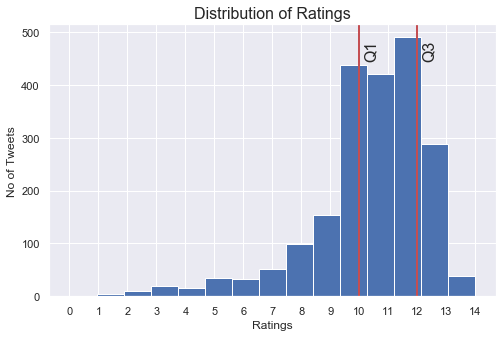

In [105]:
plt.figure(figsize=(8,5))
plt.hist(df_final['rating_numerator'],bins=15)
plt.title('Distribution of Ratings', fontsize =16)
plt.xlabel('Ratings')
plt.ylabel('No of Tweets')
plt.axvline(10,c='r',linewidth=2)
plt.text(10.15,450,'Q1',rotation=90,fontsize =16)
plt.axvline(12,c='r',linewidth=2)
plt.text(12.15,450,'Q3',rotation=90,fontsize =16)
plt.xticks(np.linspace(0,14,15));

**Note:** The distribution of rates is skewed to the left as 50% of rates less than 11 and the maximum rate is 14.

**Question-1:** What are the top 5 favorited tweets?

In [106]:
df_final.sort_values(by = 'favorite_count', ascending = False).head(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,url,name,stage,retweet_count,...,predicted_img,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
324,822872901745569793,2017-01-21 18:26:02 +0000,Twitter for iPhone,Here's a super supportive puppo participating in the Toronto #WomensMarch today. 13/10,https://twitter.com/dog_rates/status/822872901745569793/photo/1,13,https://t.co/nTz3FtorBc,NaN,puppo,48265,...,1.0,Lakeland_terrier,0.196015,True,Labrador_retriever,0.160329,True,Irish_terrier,0.069126,True
822,744234799360020481,2016-06-18 18:26:18 +0000,Twitter for iPhone,Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad),https://twitter.com/dog_rates/status/744234799360020481/video/1,13,https://t.co/7wE9LTEXC4,NaN,doggo,79515,...,1.0,Labrador_retriever,0.825333,True,ice_bear,0.044681,False,whippet,0.018442,True
60,879415818425184262,2017-06-26 19:07:24 +0000,Twitter for iPhone,This is Duddles. He did an attempt. 13/10 someone help him (vid by Georgia Felici),https://twitter.com/dog_rates/status/879415818425184262/video/1,13,https://t.co/UDT7ZkcTgY,Duddles,NaN,45849,...,1.0,English_springer,0.383404,True,Boston_bull,0.134967,True,Cardigan,0.110481,True
418,807106840509214720,2016-12-09 06:17:20 +0000,Twitter for iPhone,This is Stephan. He just wants to help. 13/10 such a good boy,https://twitter.com/dog_rates/status/807106840509214720/video/1,13,https://t.co/DkBYaCAg2d,Stephan,NaN,56625,...,1.0,Chihuahua,0.505370,True,Pomeranian,0.120358,True,toy_terrier,0.077008,True
115,866450705531457537,2017-05-22 00:28:40 +0000,Twitter for iPhone,"This is Jamesy. He gives a kiss to every other pupper he sees on his walk. 13/10 such passion, much tender","https://twitter.com/dog_rates/status/866450705531457537/photo/1,https://twitter.com/dog_rates/status/866450705531457537/photo/1",13,https://t.co/wk7TfysWHr,Jamesy,pupper,32883,...,2.0,French_bulldog,0.905334,True,Boston_bull,0.078060,True,pug,0.001771,True


**Question-2:** What are the top 5 retweeted tweets?

In [107]:
df_final.sort_values(by = 'retweet_count', ascending = False).head(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,url,name,stage,retweet_count,...,predicted_img,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
822,744234799360020481,2016-06-18 18:26:18 +0000,Twitter for iPhone,Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad),https://twitter.com/dog_rates/status/744234799360020481/video/1,13,https://t.co/7wE9LTEXC4,NaN,doggo,79515,...,1.0,Labrador_retriever,0.825333,True,ice_bear,0.044681,False,whippet,0.018442,True
418,807106840509214720,2016-12-09 06:17:20 +0000,Twitter for iPhone,This is Stephan. He just wants to help. 13/10 such a good boy,https://twitter.com/dog_rates/status/807106840509214720/video/1,13,https://t.co/DkBYaCAg2d,Stephan,NaN,56625,...,1.0,Chihuahua,0.505370,True,Pomeranian,0.120358,True,toy_terrier,0.077008,True
861,739238157791694849,2016-06-04 23:31:25 +0000,Twitter for iPhone,Here's a doggo blowing bubbles. It's downright legendary. 13/10 would watch on repeat forever (vid by Kent Duryee),https://twitter.com/dog_rates/status/739238157791694849/video/1,13,https://t.co/YcXgHfp1EC,NaN,doggo,52360,...,1.0,Eskimo_dog,0.503372,True,Siberian_husky,0.390413,True,malamute,0.080901,True
324,822872901745569793,2017-01-21 18:26:02 +0000,Twitter for iPhone,Here's a super supportive puppo participating in the Toronto #WomensMarch today. 13/10,https://twitter.com/dog_rates/status/822872901745569793/photo/1,13,https://t.co/nTz3FtorBc,NaN,puppo,48265,...,1.0,Lakeland_terrier,0.196015,True,Labrador_retriever,0.160329,True,Irish_terrier,0.069126,True
60,879415818425184262,2017-06-26 19:07:24 +0000,Twitter for iPhone,This is Duddles. He did an attempt. 13/10 someone help him (vid by Georgia Felici),https://twitter.com/dog_rates/status/879415818425184262/video/1,13,https://t.co/UDT7ZkcTgY,Duddles,NaN,45849,...,1.0,English_springer,0.383404,True,Boston_bull,0.134967,True,Cardigan,0.110481,True


**Question-3:** What is the most common stage?

pupper            220
doggo              72
puppo              23
floofer             9
doggo, pupper       9
doggo, floofer      1
doggo, puppo        1
Name: stage, dtype: int64


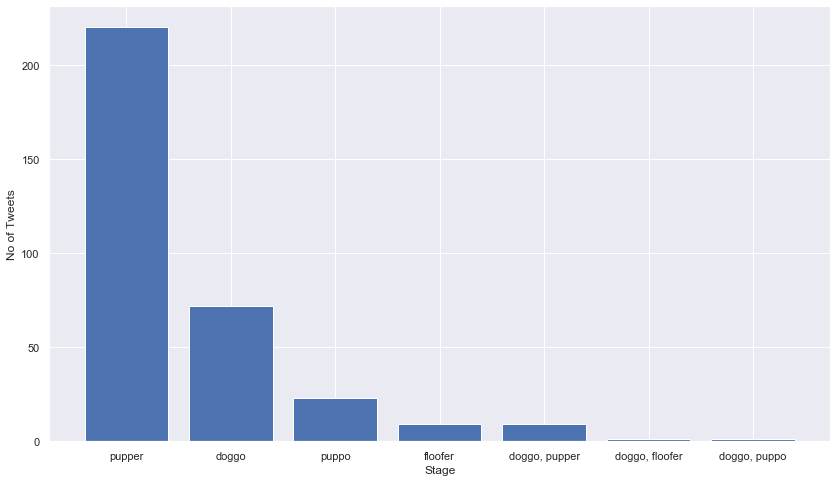

In [108]:
hcs=df_final.stage.value_counts()
print(hcs)
plt.figure(figsize=(14,8))
plt.bar(hcs.index,hcs)
plt.xlabel('Stage')
plt.ylabel('No of Tweets');

**Question-4:** What is the highest rated stage?

In [109]:
group=df_final.groupby(['stage'])['rating_numerator'].mean().sort_values()

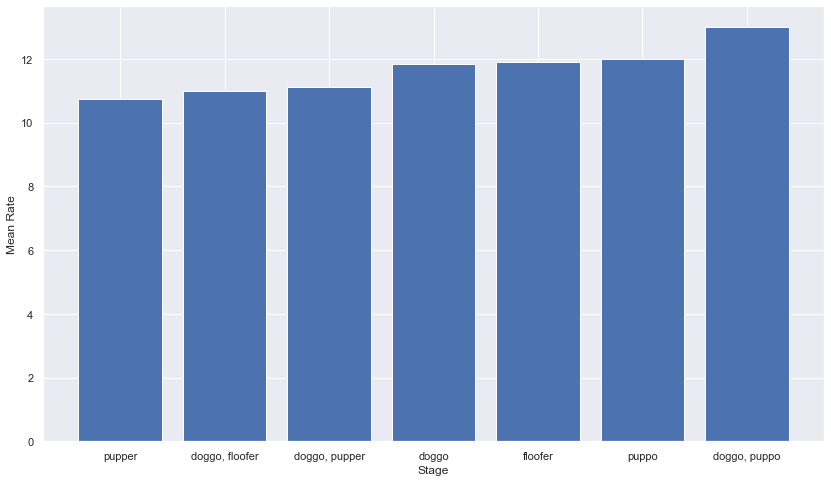

In [110]:
plt.figure(figsize=(14,8))
plt.bar(group.index,group)
plt.xlabel('Stage')
plt.ylabel('Mean Rate');

**Question-5:** which is bigger retweet count or favorite count? and what is the relationship between them?

In [111]:
fltr=df_final.retweet_count>df_final.favorite_count
print('There are {} tweets of {} total tweets whose retweet count more than its favorite count'
      .format(fltr.sum(),len(fltr)))

There are 0 tweets of 2092 total tweets whose retweet count more than its favorite count


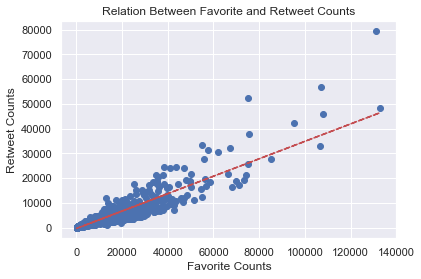

In [112]:

plt.scatter(df_final.favorite_count,df_final.retweet_count)

z = np.polyfit(df_final.favorite_count,df_final.retweet_count, 1)
p = np.poly1d(z)
plt.plot(df_final.favorite_count,p(df_final.favorite_count),"r--")


plt.xlabel('Favorite Counts')
plt.ylabel('Retweet Counts')
plt.title('Relation Between Favorite and Retweet Counts')
plt.xticks(np.linspace(0,140000,8));

**Note**
>There is a positive linear correlation between favorite and retweet Counts.

**Question-6:** What is the relationship between rates and any of favorite or retweet counts?

In [113]:
group=df_final.groupby(['rating_numerator'])[['retweet_count','favorite_count']].sum()
group

,retweet_count,favorite_count
rating_numerator,,
0,3443,24574
1,12490,27847
2,12153,20311
3,18099,45515
4,16585,40994
5,45058,133329
6,33396,86943
7,54274,153794
8,88603,239021


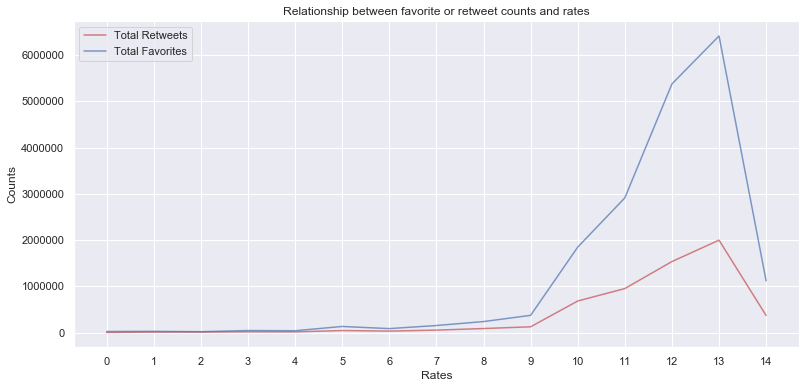

In [114]:
plt.figure(figsize=(13,6))
retweet_line = plt.plot(group.retweet_count, color='r', alpha=.7, label='Total Retweets')
favorite_line = plt.plot(group.favorite_count, color='b', alpha=.7, label='Total Favorites')
plt.ylabel('Counts')
plt.xlabel('Rates')
plt.title('Relationship between favorite or retweet counts and rates')
plt.xticks(np.linspace(0,14,15))
plt.legend();